<a href="https://colab.research.google.com/github/HyeonhoonLee/KIOM_KDC/blob/master/08_KDC_regression%2BRandomizedSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KIOM 한의임상정보은행 data 분석하기

Classification을 수행한다.

# 라이브러리 로드

In [1]:
# 분석에 사용할 pandas, 수치계산에 사용할 numpy, 시각화에 사용할 seaborn 을 불러옵니다.
# 또, 구 버전의 주피터 노트북에서는 %matplotlib inline 설정을 되어야 노트북 안에서 그래프를 시각화 합니다.

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#한글 폰트 설정

In [2]:
# Google Colab 사용 시 아래 주석을 풀고 폰트설정을 합니다.
# 로컬 아나콘다 사용 시에는 그대로 주석처리 해놓으시면 됩니다.
# 나눔고딕 설치
# 이 코드를 사용시 아래에 있는 폰트를 로드할 경우 colab에서는 오류가 발생하니
# 아래에 있는 폰트 설정은 꼭 주석처리를 해주세요. 
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

fm._rebuild()

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumGothic') 
# 마이너스 폰트 깨지는 문제에 대한 대처
plt.rc("axes", unicode_minus=False)

In [3]:
# 레티나 설정을 해주면 글씨가 좀 더 선명하게 보입니다.
# 폰트의 주변이 흐릿하게 보이는 것을 방지합니다.
%config InlineBackend.figure_format = 'retina'

#데이터 불러오기

- 데이터 로드 주소: https://www.data.go.kr/data/3072201/fileData.do
- 임상정보은행 사이트에서 상세이용방법 확인가능 (https://kdc.kiom.re.kr/html/?pmode=subpage&MMC_pid=200&spSeq=22)

In [4]:
# 다운로드 받은 파일을 판다스의 read_csv 를 통해 읽어옵니다.
# 파일을 읽어온 후 shape 로 행과 열의 수를 출력합니다.

##새로만든 csv에는 인코딩을 따로 지정하지 않아도된다.
df = pd.read_csv("/content/drive/My Drive/DataCollection/KIOM_KDC/data/한의임상정보은행 교육용 데이터 (2016.10.27)..csv", encoding="cp949")
df.shape

(500, 73)

In [5]:
# sample, head, tail을 통해 데이터를 미리보기 합니다.
df.head()

,대상자식별코드,성별,만나이,직업분류,학력,결혼유무,음주력,흡연력,성격_대범_섬세,성격_행동빠름_행동느림,성격_적극_소극,성격_직접_간접,성격_포기빠름_포기느림,성격_외향_내성,성격_동적_정적,성격_쉽게_어렵게,성격_남성적_여성적,성격_참을성부족_잘찾음,성격_큰편_적은편,성격_잘드러냄_안드러냄,성격_잘표현_표현안하는편,성격_가끔흥분_이성적,성격_덜렁_꼼꼼,식사량,식사속도,소화여부,소화입맛,땀정도,땀기분,대변습관,대변굳기,배변시긴박감,배변후잔변감,소변야간뇨,한열민감도,한열손부위,한열발부위,한열배부위,음수정도,음수온다,한열점수,한열그룹,고혈압_진단,당뇨_진단,고지혈증_진단,일반건강,수면시간(시간),수면시간(분),피로정도,피로_기상시,피로_오전,피로_오후,피로_밤,피로_하루종일,한의사체질진단,키,몸무게,BMI,이마둘레,목둘레,겨드랑이둘레,가슴둘레,늑골둘레,허리둘레,장골둘레,곡골둘레,수축기혈합,이완기혈압,혈당,총콜레스테롤,중성지방,고밀도콜레스테롤,저밀도콜레스테롤
0,KDCT00001,2,48.666,2,5,2,999,999,2,2,1,2,1,1,1,2,2,3,2,2,2,1,1,2,2,1,3,3,1,1,2,999,999,1.0,1,2,2,2,2,2,12,2,1,1,1,3,5,0,2,0,0,0,1,0,2,158.0,55.0,22.0,53.0,33.0,92.0,96.0,89.0,82.0,91.0,96.0,120,80,104,219,72,60,128
1,KDCT00002,2,80.773,14,3,2,999,999,1,1,1,1,1,1,1,2,1,3,1,1,1,1,3,2,2,1,3,1,2,1,2,999,999,1.0,2,2,2,2,2,3,13,3,1,1,1,3,5,0,4,0,0,1,0,0,3,155.0,63.0,26.2,59.0,35.0,96.0,101.0,93.0,92.0,96.0,99.0,124,65,110,199,97,46,114
2,KDCT00003,1,50.008,3,3,2,999,999,3,1,1,1,1,1,1,1,1,2,1,1,1,1,3,3,2,3,2,3,1,1,2,999,999,1.0,3,2,3,2,2,2,12,2,1,1,1,3,7,0,2,0,0,1,0,0,2,160.0,59.0,23.0,57.0,37.0,95.0,90.0,83.0,80.0,81.0,81.0,121,75,79,216,88,49,132
3,KDCT00004,2,50.551,14,4,2,999,999,1,1,1,1,1,1,1,2,1,1,1,2,1,1,2,999,1,3,2,2,3,2,2,999,999,1.0,2,2,2,2,1,2,15,3,1,1,1,4,7,0,4,0,0,1,0,0,2,165.0,76.0,27.9,59.0,37.0,100.0,104.0,90.0,91.0,94.0,99.0,113,81,100,218,136,44,136
4,KDCT00005,1,49.581,8,2,2,999,999,3,2,3,2,2,3,2,2,2,3,3,2,2,2,1,2,1,1,3,1,2,1,2,999,999,0.0,1,3,3,2,1,2,11,2,1,1,1,2,5,0,4,0,0,1,0,0,1,165.0,70.0,25.7,60.0,40.0,106.0,102.0,99.0,98.0,98.0,100.0,129,72,92,186,61,33,118


In [6]:
# 본 실습에서는 연속형 변수 중 결측치가 얼마 없어서, 저밀도콜레스테롤을 회귀분석으로 예측해봅니다. 
## 일단, 나머지 결측치는 처리하지 않고 진행해봅니다.

# 학습, 예측 데이터셋 나누기

In [7]:
# label 값을 기준으로 나눕니다.
# 나누기 전에 label 값을 시각화 합니다.
(df["저밀도콜레스테롤"] < 999).value_counts()

True     497
False      3
Name: 저밀도콜레스테롤, dtype: int64

In [8]:
# train 세트를 만듭니다.

train = df[df["저밀도콜레스테롤"] < 999].copy()
train.shape

(497, 73)

In [9]:
# test 세트를 만듭니다.

test = df[df["저밀도콜레스테롤"] == 999].copy()
test.shape

(3, 73)

# EDA (1단계에서는 pass)
- 아래의 6개 코드는, 1차로 오차를 구하고난 뒤 다시 수행한 코드이다.
- Outlier를 없애주기 위한 과정(EDA 및 feature engineering)이다.

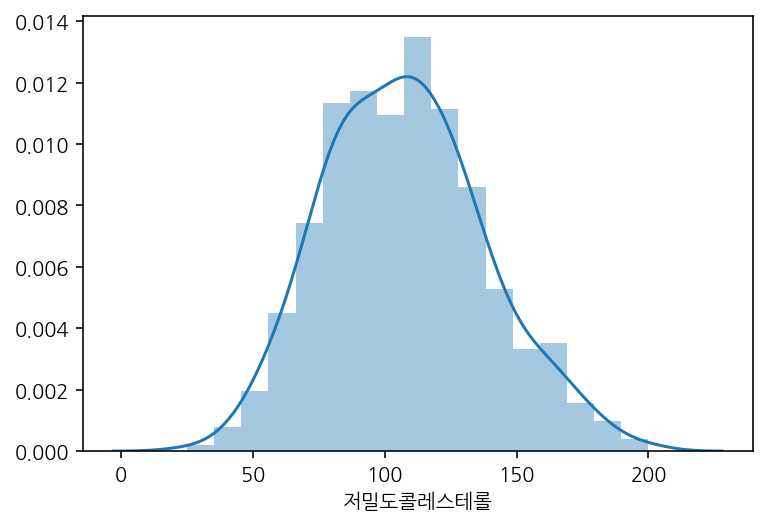

In [10]:
# 먼저 간단한 EDA를 해준다.
# test에 있는 값은 모두 999이므로 의미없다.
sns.distplot(train["저밀도콜레스테롤"])

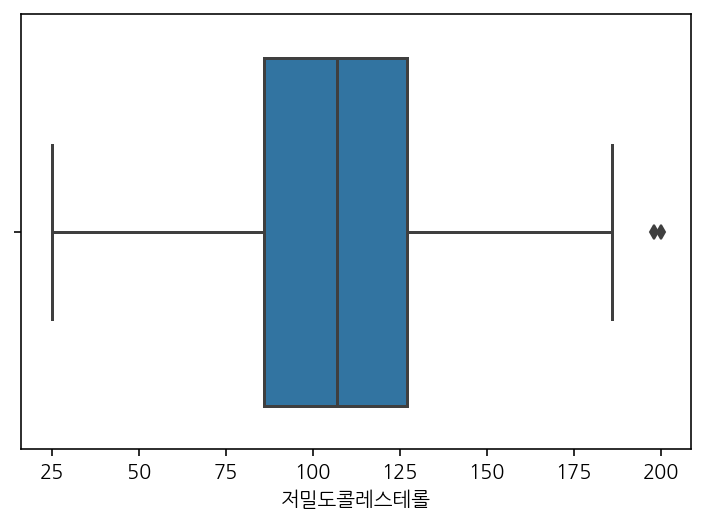

In [11]:
# 이상치를 볼 때는 주로 boxplot을 쓴다.
sns.boxplot(train["저밀도콜레스테롤"])

In [12]:
desc = train["저밀도콜레스테롤"].describe()
desc

count    497.000000
mean     107.609658
std       30.422902
min       25.000000
25%       86.000000
50%      107.000000
75%      127.000000
max      200.000000
Name: 저밀도콜레스테롤, dtype: float64

In [13]:
# Outlier의 기준값을 구해본다.
# IQR =  3IQR - 1IQR
# OUT > 3IQR + (IQR * 1.5)
IQR = desc.loc["75%"] - desc.loc["25%"]
OUT = desc.loc["75%"] + (IQR * 1.5)

In [14]:
train[train["저밀도콜레스테롤"] > OUT].shape

(2, 73)

In [15]:
print(train.shape)
train = train[train["저밀도콜레스테롤"] < OUT]
train.shape

(497, 73)


(495, 73)


# 학습, 예측에 사용할 컬럼

In [16]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.
# train.columns.tolist()로 가져와도된다. 
# 맨 처음 컬럼인 대상자식별코드는 제외한다.
feature_names = test.columns[1:].tolist()
feature_names.remove("저밀도콜레스테롤")
feature_names

['성별',
 '만나이',
 '직업분류',
 '학력',
 '결혼유무',
 '음주력',
 '흡연력',
 '성격_대범_섬세',
 '성격_행동빠름_행동느림',
 '성격_적극_소극',
 '성격_직접_간접',
 '성격_포기빠름_포기느림',
 '성격_외향_내성',
 '성격_동적_정적',
 '성격_쉽게_어렵게',
 '성격_남성적_여성적',
 '성격_참을성부족_잘찾음',
 '성격_큰편_적은편',
 '성격_잘드러냄_안드러냄',
 '성격_잘표현_표현안하는편',
 '성격_가끔흥분_이성적',
 '성격_덜렁_꼼꼼',
 '식사량',
 '식사속도',
 '소화여부',
 '소화입맛',
 '땀정도',
 '땀기분',
 '대변습관',
 '대변굳기',
 '배변시긴박감',
 '배변후잔변감',
 '소변야간뇨',
 '한열민감도',
 '한열손부위',
 '한열발부위',
 '한열배부위',
 '음수정도',
 '음수온다',
 '한열점수',
 '한열그룹',
 '고혈압_진단',
 '당뇨_진단',
 '고지혈증_진단',
 '일반건강',
 '수면시간(시간)',
 '수면시간(분)',
 '피로정도',
 '피로_기상시',
 '피로_오전',
 '피로_오후',
 '피로_밤',
 '피로_하루종일',
 '한의사체질진단',
 '키',
 '몸무게',
 'BMI',
 '이마둘레',
 '목둘레',
 '겨드랑이둘레',
 '가슴둘레',
 '늑골둘레',
 '허리둘레',
 '장골둘레',
 '곡골둘레',
 '수축기혈합',
 '이완기혈압',
 '혈당',
 '총콜레스테롤',
 '중성지방',
 '고밀도콜레스테롤']

# 정답값이자 예측해야 될 값

In [17]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.

label_name = "저밀도콜레스테롤"
label_name

'저밀도콜레스테롤'

# 학습, 예측 데이터셋 만들기

In [18]:
# "저밀도콜레스테롤" data가 있는지 여부에 따라 train과 test로 나뉜다.

In [19]:
# 학습 세트 만들기 예) 시험의 기출문제

X_train = train[feature_names]
X_train.shape

(495, 71)

In [20]:
# 정답 값을 만들어 줍니다. 예) 기출문제의 정답
y_train = train[label_name]
y_train.shape

(495,)

In [21]:
# 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제

X_test = test[feature_names]
X_test.shape

(3, 71)

In [22]:
# 예측의 정답값 예) 실전 시험 문제의 정답
## 결측치에 해당하므로 정답값은 모두 999다.
y_test = test[label_name]
y_test.shape

(3,)

# 머신러닝 알고리즘 가져오기

In [ ]:
from sklearn.tree import DecisionTreeRegressor
#DecisionTreeClassifier와 hyperparameter가 같다.
model = DecisionTreeRegressor(random_state=42)
model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

## RandomizedSearchCV를 이용한 최적의 모델 및 파라미터 찾기

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

estimators = [DecisionTreeRegressor(random_state=42),
         RandomForestRegressor(random_state=42),
         GradientBoostingRegressor(random_state=42)
        ]
estimators

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False),
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
            

In [26]:
# max_depth = np.random.randint(5, 30, 10)
# max_depth

In [27]:
# max_features = np.random.uniform(0.3, 1.0, 10)
# max_features

In [28]:
# results = []
# for estimator in estimators:
#     result = []
#     result.append(estimator.__class__.__name__)
#     results.append(result)

# pd.DataFrame(results)

In [29]:
##위의 3개 셀의 코드와 같이 loop문에 들어갈 것을 나눠서 실행해본 후에,
##아래의 loop문에 넣어주는 습관이 좋을 수 있다.

In [30]:
from sklearn.model_selection import RandomizedSearchCV

results = []
for estimator in estimators:
    result = []
    #max_depth와 max_features를 random으로 생성하는 숫자의 갯수는 n_iter 값 이상이면된다.
    #n_iter값 까지만 random으로 생성된 숫자가 이용될 것이기 때문이다.(여기서는 100으로 똑같이 맞춰줌.)

    max_depth = np.random.randint(5, 30, 100)
    max_features = np.random.uniform(0.3, 1.0, 100)

    param_distributions = {"max_depth": max_depth, "max_features": max_features }

    regressor = RandomizedSearchCV(estimator,
        param_distributions,
        n_iter=100,
        scoring=None,
        n_jobs=-1,
        cv=5,
        verbose=2, 
        random_state=42)

    regressor.fit(X_train, y_train)
    
    result.append(estimator.__class__.__name__)
    result.append(regressor.best_params_)
    result.append(regressor.best_estimator_)
    result.append(regressor.best_score_)
    result.append(regressor.cv_results_)
    results.append(result)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished


In [31]:
#이 표에서의 score는 r2 score
df_cv = pd.DataFrame(results)
df_cv.columns = ["model", "params", "estimator", "score", "cv_result"]
df_cv

,model,params,estimator,score,cv_result
0,DecisionTreeRegressor,"{'max_features': 0.9298786846719516, 'max_dept...","DecisionTreeRegressor(ccp_alpha=0.0, criterion...",0.742342,"{'mean_fit_time': [0.013790082931518555, 0.019..."
1,RandomForestRegressor,"{'max_features': 0.969568577195304, 'max_depth...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.836036,"{'mean_fit_time': [1.0653296947479247, 0.63576..."
2,GradientBoostingRegressor,"{'max_features': 0.7399959709365509, 'max_dept...","([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.839524,"{'mean_fit_time': [0.5214650630950928, 0.53803..."


In [44]:
# 위의 표에서 score 값을 바탕으로 best_estimator를 선택하여 인덱싱한다.
best_estimator = df_cv.loc[2, "estimator"]
best_estimator

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=0.7399959709365509, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# 학습(훈련)
* 시험을 볼 때 기출문제(X_train)와 정답(y_train)을 보고 공부하는 과정과 유사합니다.

In [45]:
best_estimator.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=0.7399959709365509, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# cross validation 으로 학습 세트의 오차 측정하기
- The function **cross_val_predict** has a similar interface to **cross_val_score**, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set.
- => CV 중 test set에 속했을 때 나온 prediction값을 리턴한다는 의미.
- https://scikit-learn.org/stable/modules/cross_validation.html

In [46]:
## import뒤에 cross_를 입력하면 cross_val_predict, cross_val_score, cross_validate 3가지가
## 나오는데, 이 중 cross_val_predict를 선택하면 "예측값"을 반환한다.
## cv=5이므로, 총 5번을 fit하게 된다.
## cv값을 높여서, 즉 fit을 여러번할 수록 더 정확한 예측값을 얻을 수 있다.
from sklearn.model_selection import cross_val_predict

y_predict = cross_val_predict(best_estimator, X_train, y_train, cv=5, verbose=2, n_jobs=-1)
y_predict[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


array([123.16975992, 122.85999571, 133.18311502, 138.08472435,
       113.14534902])

In [47]:
# 정답을 정확하게 맞춘 갯수
## 회귀에서는 맞춘 갯수가 크게 의미 있지는 않다. 범위가 넓게 때문에.
#1 15
#2 9
#3 (best_estimator): 0
(y_predict == y_train).sum()

0

In [48]:
# 전체 정답 갯수.
len(y_train)
##1 즉 정확하게 맞출 확률은 0/495.

495

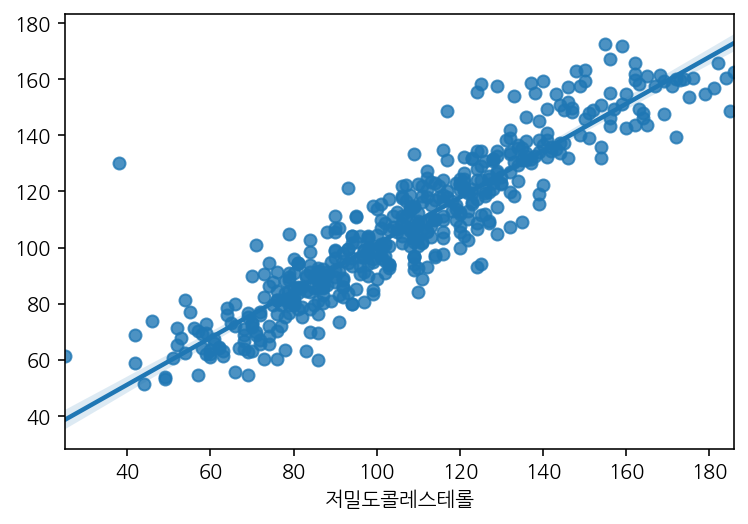

In [49]:
# regplot 으로 결과 값을 비교합니다.

sns.regplot(y_train, y_predict)

In [ ]:
# (1차 진행 후)
# 여기서 보이는 outlier들이 오버피팅이 되거나, 제대로 예측을 하는데 도움이 되지 않을 수 
# 있기 때문에(오차를 높임), 이를 제거해주기 위해 다시 학습/예측 데이터셋 나누기로 올라간다.

### **결정계수(R2 score)** (self로 찾아본 것)
- 선형회귀분석(linear regression analysis)에서 회귀직선의 적합도(goodness-of-fit)를 평가하거나 종속변수에 대한 설명변수들의 설명력을 알고자 할 때 결정계수(R sqaured, coefficient of determination))를 이용합니다.
- 예를 들어 결정계수 R2=0.45 인 경우, 소아의 인지기능(종속변수) 변동은 언어학습시간(독립변수) 변동에 의해 45% 정도 설명된다고 해석할 수 있습니다.
- 결정계수는 피어슨 상관계수 (Pearson correlation coefficient)의 제곱과도 같습니다.위에서 언급한 것과 같이 상관계수는 -1~1 사이의 값을 갖기 때문에 결정계수는 0부터 1까지의 값을 갖게 됩니다.
- https://mansoostat.tistory.com/76

In [50]:
# r2_score 를 구합니다.

from sklearn.metrics import r2_score

r2_score(y_train, y_predict)

# 결국 regplot으로 그린 회귀선이 60% 정도의 설명력을 가진다는 얘기.

0.8414127236535693

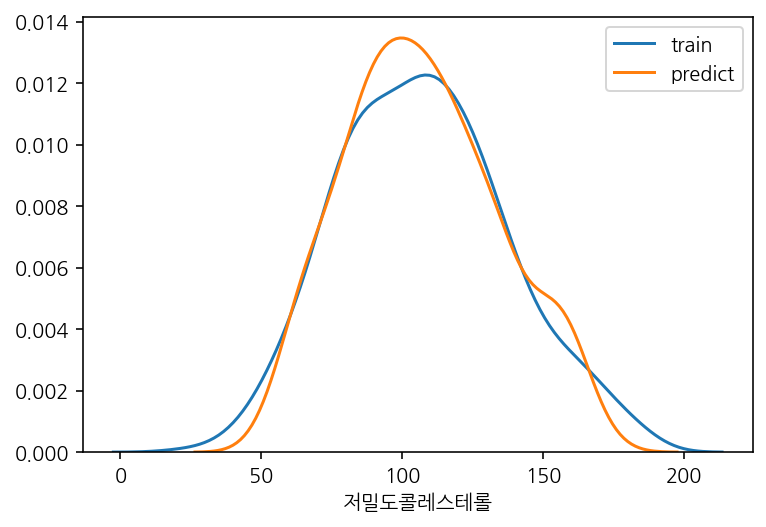

In [51]:
# distplot으로 정답값과 예측값의 분포를 그립니다.
# displot에서 label을 그리기위해서는 histogram를 제거해줘야한다.

sns.distplot(y_train, hist=False, label="train")
sns.distplot(y_predict, hist=False, label="predict")

# 오차 구하기

## MAE

In [52]:
# MAE (Mean Absolute Error)
#1 13.66
#2 13.39
#3 (best_estimator) 8.77

##abs()는 절댓값으로 바꿔준다.
error = abs(y_train - y_predict)
error.mean()

8.773416252017272

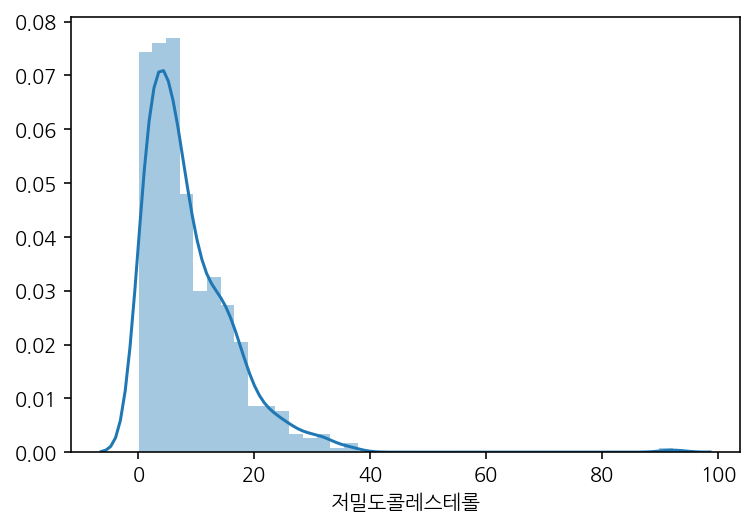

In [53]:
sns.distplot(error)
#1 주로 오차가 작은 값에 몰려있지만, 40이상 되는 오차도 있다는 것을 확인할 수 있다.
# 오차가 큰 값들 때문에 mean값이 편향되었을 것이라고 예상할 수 있다.

In [54]:
# 오차값을 분석해본다.
error.describe()

count    495.000000
mean       8.773416
std        8.053674
min        0.028755
25%        3.150118
50%        6.562846
75%       12.601963
max       92.157577
Name: 저밀도콜레스테롤, dtype: float64

## RMSE
- 회귀의 정확도를 구할 때는 보통 RMSE 공식을 많이 사용한다.
- 표준편차 구하는 공식과 유사하다.


In [55]:
# RMSE(Root Mean Square Error): 뒤(E)에서 부터 해석해보면 아래 공식을 유도할 수 있다.
#1 19.10
#2 18.53 ("저밀도콜레스테롤"의 outlier 제거)
#3 (best_estimator) 11.90

np.sqrt(((y_train - y_predict) ** 2).mean())

11.903926394212771

# 트리 알고리즘 분석하기
* 의사결정나무를 시각화 합니다.
* 피처의 중요도를 구합니다.

In [ ]:
# plot_tree로 시각화 하기

from sklearn.tree import plot_tree

plt.figure(figsize=(20, 20))
tree = plot_tree(model, 
          feature_names=feature_names, 
          filled=True,
          fontsize=10)

In [ ]:
#graphviz 를 통해 시각화 합니다.
#graphviz 는 별도의 설치가 필요합니다. 
#graphviz 와 파이썬에서 graphviz 를 사용할 수 있게 해주는 도구 2가지를 설치해 주셔야 합니다.
import graphviz
from sklearn.tree import export_graphviz

dot_tree = export_graphviz(model,
                           feature_names = feature_names,
                           filled=True)
graphviz.Source(dot_tree)

In [73]:
# 피처의 중요도를 추출하기
best_estimator.feature_importances_

array([7.33766780e-05, 8.18818752e-03, 7.79492304e-04, 6.12020101e-04,
       1.90527319e-04, 6.12464391e-05, 5.50674035e-05, 6.91504489e-04,
       7.81516068e-04, 2.54897920e-04, 1.28169145e-03, 1.57727292e-03,
       3.04629449e-04, 4.73826735e-04, 8.55256584e-04, 1.06008549e-04,
       2.55228278e-04, 7.79572891e-04, 9.89011755e-04, 5.64050090e-04,
       1.93883320e-03, 9.31020742e-04, 8.07281713e-04, 4.72179873e-04,
       1.03265798e-04, 1.75799873e-03, 2.01267281e-04, 6.35921501e-04,
       8.97314738e-05, 9.11696857e-04, 3.63838931e-03, 4.68570334e-03,
       7.24939032e-04, 2.53639533e-04, 2.24355850e-04, 1.98720289e-04,
       6.22594234e-04, 1.51541608e-03, 8.23125944e-04, 2.71062775e-03,
       9.84131071e-04, 5.05631700e-04, 8.37246762e-05, 4.54424994e-04,
       7.63604190e-04, 2.17176962e-03, 4.48024166e-04, 2.33441741e-03,
       6.24569533e-04, 8.33967992e-04, 9.17217428e-05, 7.30867380e-05,
       5.84923119e-04, 1.14374976e-03, 3.59610262e-03, 2.02042885e-03,
      

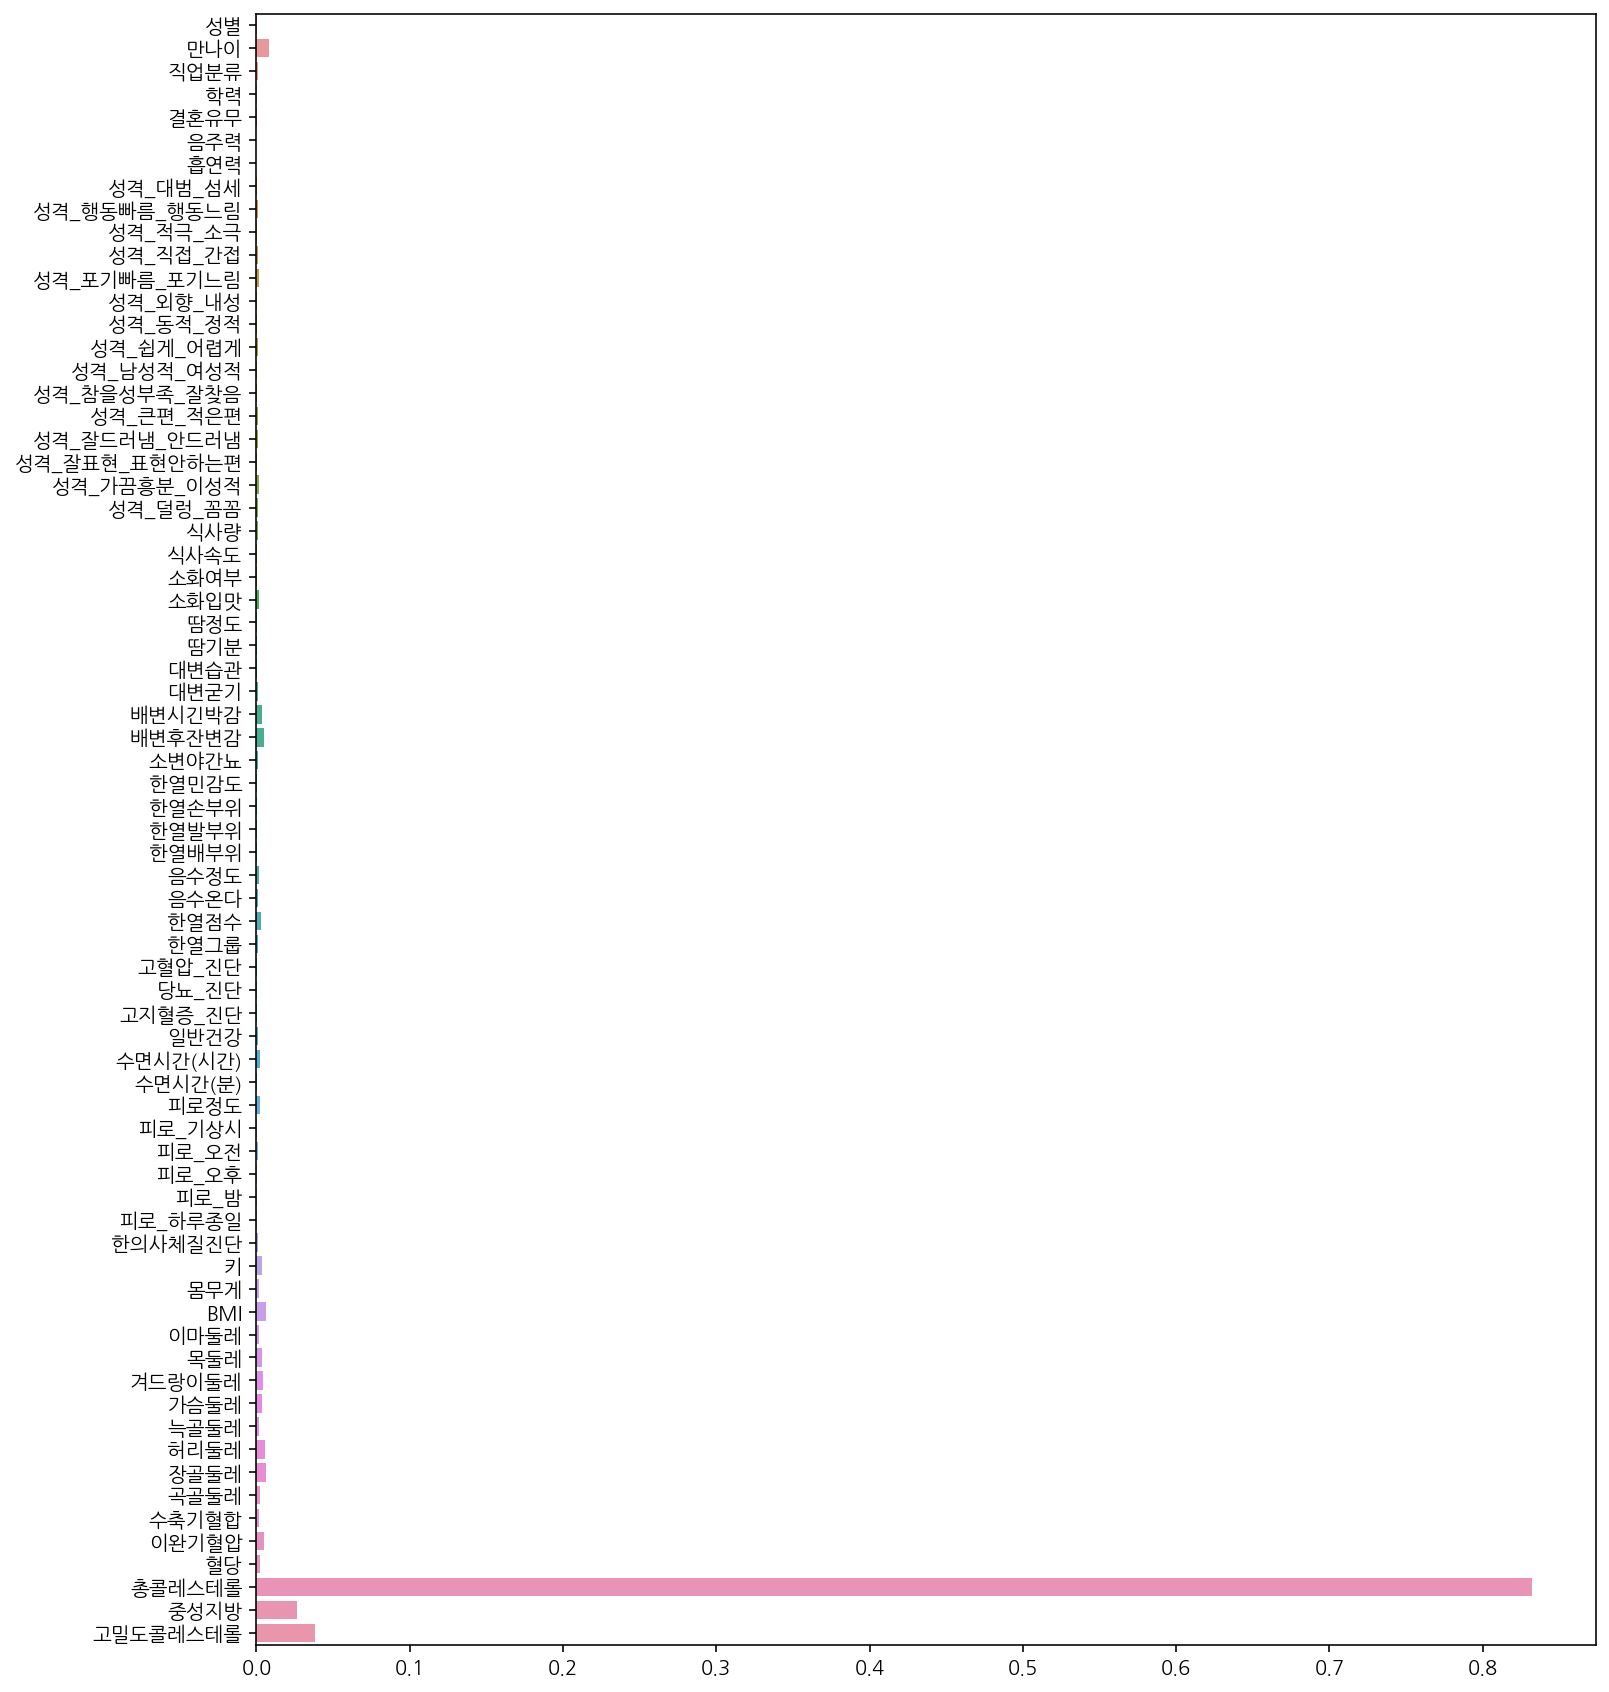

In [74]:
# 피처의 중요도 시각화 하기
plt.figure(figsize=(12,15))
sns.barplot(x=best_estimator.feature_importances_, y=feature_names)

# 예측
* 실전 시험문제(X_test)라고 보면 됩니다. 우리가 정답을 직접 예측합니다.
* 저밀도콜레스테롤이 999인 값을 예측 했기 때문에 정답을 알 수 없습니다.
* 따라서 점수는 train set로 측정한 값을 참고합니다.

In [67]:
y_test = best_estimator.predict(X_test)
y_test[:5]

array([145.09018246, 159.59836595, 158.604238  ])

In [57]:
#이렇게 구한 값(y_test)을 "저밀도콜레스테롤"=999 에다가 전처리해서 넣어줌으로써
#결측치 처리를 하고 다시 classification을 진행할 수 있다.

In [68]:
train.groupby("한의사체질진단")["저밀도콜레스테롤"].describe()

,count,mean,std,min,25%,50%,75%,max
한의사체질진단,,,,,,,,
1,199.0,109.949749,29.790133,25.0,88.0,110.0,128.0,186.0
2,123.0,103.414634,29.323780,49.0,81.0,99.0,121.0,185.0
3,173.0,106.843931,30.345950,42.0,86.0,108.0,127.0,179.0


In [69]:
# y_test값을 test set에 넣어준다.
test["저밀도콜레스테롤"] = y_test

In [70]:
test.groupby("한의사체질진단")["저밀도콜레스테롤"].describe()

,count,mean,std,min,25%,50%,75%,max
한의사체질진단,,,,,,,,
1,1.0,159.598366,NaN,159.598366,159.598366,159.598366,159.598366,159.598366
2,1.0,145.090182,NaN,145.090182,145.090182,145.090182,145.090182,145.090182
3,1.0,158.604238,NaN,158.604238,158.604238,158.604238,158.604238,158.604238


In [61]:
#위의 두 테이블을 비교함으로써 regression을 통해 얼마나 잘 예측했는지 살펴볼 수 있다.
## 즉, 두 train과 test가 균질해질수록 잘 예측(여기서는 결측치 처리)한 것으로 추론할 수 있다.

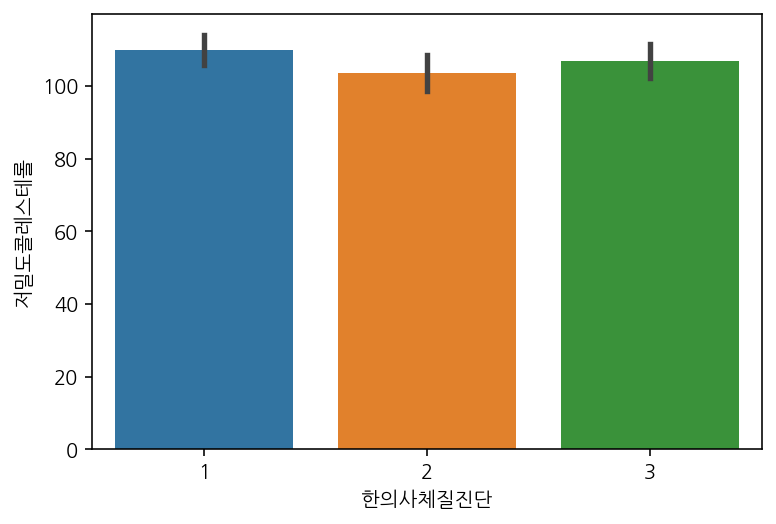

In [71]:
# "저밀도콜레스테롤" 평균값을 출력
sns.barplot(data=train, x="한의사체질진단", y="저밀도콜레스테롤")

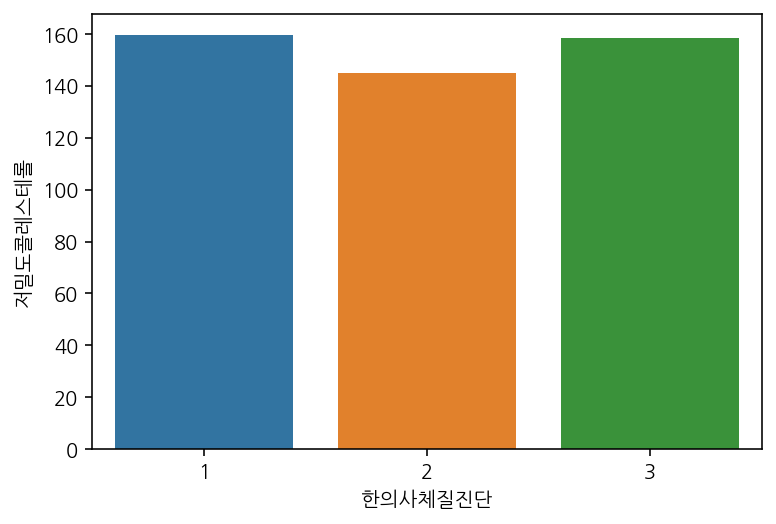

In [72]:
# 예측값
sns.barplot(data=test, x="한의사체질진단", y="저밀도콜레스테롤")

In [64]:
#위의 두 barplot을 비교함으로써 regression을 통해 얼마나 잘 예측했는지 살펴볼 수 있다.
## 즉, 두 train과 test가 균질해질수록 잘 예측(여기서는 결측치 처리)한 것으로 추론할 수 있다.

In [65]:
#1 regression을 처음부터 끝까지 쭉 해봄: MAE 13.66 / RMSE 19.10
#2 저밀도콜레스테롤의 outlier 제거 후 오차가 낮아짐: MAE 13.39 / RMSE 18.53
#3 RandomizedSearchCV를 이용한 best_parameter를 이용한 후: MAE 8.77 / RMSE 11.90

## 예측값을 CSV 파일로 저장하기
* 랜덤값을 넣어서 최적의 파라메터를 찾았기 때문에 예측이 매번 달라질 수 있다.

In [75]:
df.loc[df["저밀도콜레스테롤"] == 999, "저밀도콜레스테롤"]

69     999
123    999
127    999
Name: 저밀도콜레스테롤, dtype: int64

In [78]:
#위의 series와 index 번호가 같음을 확인
test["저밀도콜레스테롤"]

69     145.090182
123    159.598366
127    158.604238
Name: 저밀도콜레스테롤, dtype: float64

In [ ]:
df.loc[df["저밀도콜레스테롤"] == 999, "저밀도콜레스테롤"] = test["저밀도콜레스테롤"]

In [86]:
#KDC의 dataframe의 경우 "대상자식별코드"가 따로 있기 때문에, index를 False로 해준다.
df.to_csv("/content/drive/My Drive/DataCollection/KIOM_KDC/data/diabetes_fill_insulin.csv", index=False)

In [87]:
pd.read_csv("/content/drive/My Drive/DataCollection/KIOM_KDC/data/diabetes_fill_insulin.csv")

,대상자식별코드,성별,만나이,직업분류,학력,결혼유무,음주력,흡연력,성격_대범_섬세,성격_행동빠름_행동느림,성격_적극_소극,성격_직접_간접,성격_포기빠름_포기느림,성격_외향_내성,성격_동적_정적,성격_쉽게_어렵게,성격_남성적_여성적,성격_참을성부족_잘찾음,성격_큰편_적은편,성격_잘드러냄_안드러냄,성격_잘표현_표현안하는편,성격_가끔흥분_이성적,성격_덜렁_꼼꼼,식사량,식사속도,소화여부,소화입맛,땀정도,땀기분,대변습관,대변굳기,배변시긴박감,배변후잔변감,소변야간뇨,한열민감도,한열손부위,한열발부위,한열배부위,음수정도,음수온다,한열점수,한열그룹,고혈압_진단,당뇨_진단,고지혈증_진단,일반건강,수면시간(시간),수면시간(분),피로정도,피로_기상시,피로_오전,피로_오후,피로_밤,피로_하루종일,한의사체질진단,키,몸무게,BMI,이마둘레,목둘레,겨드랑이둘레,가슴둘레,늑골둘레,허리둘레,장골둘레,곡골둘레,수축기혈합,이완기혈압,혈당,총콜레스테롤,중성지방,고밀도콜레스테롤,저밀도콜레스테롤
0,KDCT00001,2,48.666,2,5,2,999,999,2,2,1,2,1,1,1,2,2,3,2,2,2,1,1,2,2,1,3,3,1,1,2,999,999,1.0,1,2,2,2,2,2,12,2,1,1,1,3,5,0,2,0,0,0,1,0,2,158.0,55.0,22.0,53.0,33.0,92.0,96.0,89.0,82.0,91.0,96.0,120,80,104,219,72,60,128.0
1,KDCT00002,2,80.773,14,3,2,999,999,1,1,1,1,1,1,1,2,1,3,1,1,1,1,3,2,2,1,3,1,2,1,2,999,999,1.0,2,2,2,2,2,3,13,3,1,1,1,3,5,0,4,0,0,1,0,0,3,155.0,63.0,26.2,59.0,35.0,96.0,101.0,93.0,92.0,96.0,99.0,124,65,110,199,97,46,114.0
2,KDCT00003,1,50.008,3,3,2,999,999,3,1,1,1,1,1,1,1,1,2,1,1,1,1,3,3,2,3,2,3,1,1,2,999,999,1.0,3,2,3,2,2,2,12,2,1,1,1,3,7,0,2,0,0,1,0,0,2,160.0,59.0,23.0,57.0,37.0,95.0,90.0,83.0,80.0,81.0,81.0,121,75,79,216,88,49,132.0
3,KDCT00004,2,50.551,14,4,2,999,999,1,1,1,1,1,1,1,2,1,1,1,2,1,1,2,999,1,3,2,2,3,2,2,999,999,1.0,2,2,2,2,1,2,15,3,1,1,1,4,7,0,4,0,0,1,0,0,2,165.0,76.0,27.9,59.0,37.0,100.0,104.0,90.0,91.0,94.0,99.0,113,81,100,218,136,44,136.0
4,KDCT00005,1,49.581,8,2,2,999,999,3,2,3,2,2,3,2,2,2,3,3,2,2,2,1,2,1,1,3,1,2,1,2,999,999,0.0,1,3,3,2,1,2,11,2,1,1,1,2,5,0,4,0,0,1,0,0,1,165.0,70.0,25.7,60.0,40.0,106.0,102.0,99.0,98.0,98.0,100.0,129,72,92,186,61,33,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,KDCT00496,1,50.682,3,5,2,1,2,3,1,2,2,1,2,2,1,2,3,2,3,3,2,3,2,999,1,2,1,3,1,2,3,3,1.0,1,3,3,3,2,2,9,1,2,1,1,3,7,0,3,0,0,1,0,0,1,164.5,57.9,21.4,55.3,36.0,89.0,86.5,83.2,74.5,80.0,88.0,120,80,71,190,75,73,101.0
496,KDCT00497,2,42.542,3,5,2,2,3,3,1,3,3,1,3,3,2,3,3,2,3,3,2,3,2,999,3,3,3,3,2,2,3,3,1.0,3,3,3,2,3,1,8,1,1,1,1,3,6,0,3,0,0,1,0,0,2,157.2,41.9,17.0,53.5,32.0,73.5,76.0,67.0,64.5,76.0,79.0,110,70,74,246,86,104,117.0
497,KDCT00498,1,48.797,7,5,2,1,2,3,2,2,2,2,2,3,2,2,2,1,3,2,2,2,2,999,1,3,2,1,2,2,3,2,0.0,2,1,1,1,2,2,17,3,2,1,2,4,6,0,2,1,0,1,0,0,3,165.0,82.0,30.1,58.0,41.0,105.5,104.0,99.7,95.0,96.5,97.5,150,100,125,246,220,74,154.0
498,KDCT00499,1,51.263,7,4,2,1,1,3,2,1,1,1,1,1,1,1,3,2,1,2,3,3,2,999,3,2,2,1,1,2,2,3,1.0,2,3,2,2,1,2,14,3,2,1,1,2,7,0,2,0,0,1,0,0,3,171.1,68.3,23.3,54.4,38.0,97.3,94.0,87.0,86.0,89.5,91.4,110,80,85,172,127,49,109.0
